Adversarial Training on CIFAR-10 with FGSM attacks

In this notebook, we are trying to improve robustness of ResNet-18 model on CIFAR-10 data.
we used adversarial training methodes and Circle loss function[1].
for creatig adversarial data we used FGSM (Fast Gradient Signed Method)

[1]Yifan Sun, Changmao Cheng, Yuhan Zhang, Chi Zhang, Liang Zheng,
Zhongdao Wang, and Yichen Wei. Circle loss: A unified perspective of pair
similarity optimization. In CVPR, pages 6398–6407, 2020.

In [1]:
!pip install pytorch-metric-learning
!pip install umap-learn
!pip install umap
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=75d968747aa16a8292aaaf63635688cc5c9db4ee28ea253280c9dc36023f6f8b
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [4]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *
from torchvision.transforms.functional import resize
import torchvision
import torchvision.transforms as transforms
import random
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
import pickle
from sklearn.neighbors import KNeighborsClassifier
from pytorch_metric_learning import losses

we used 80% of data for training, 20% for test

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01
epsilon=0.1
# Define transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Split trainset into train and validation
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(
    validset, batch_size=100, shuffle=False, num_workers=2)

# Load test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 77785345.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


buildig resnet model

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 10)  # Changing the output layer for CIFAR-10

    def forward(self, x):
        return self.resnet(x)

# Load pre-trained ResNet-18 model
model = Net()
model.eval()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s] 


# in the first part of code, we trying to create adversarial examples.

for creating adversarial examples, we used below equation:

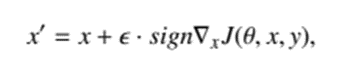

In [7]:

def FGSM(net, x, y, eps):

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()

        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert

creating adversarial example and randomly perturb 10 pixels of eaach sample

In [8]:
def perturb_image(image, num_pixels=10):
    """
    Randomly perturb `num_pixels` pixels of the input image.
    """
    perturbed_image = image.clone()

    for _ in range(num_pixels):
        # Randomly select pixel coordinates
        x = random.randint(0, image.size(2) - 1)
        y = random.randint(0, image.size(3) - 1)

        # Randomly perturb pixel value
        perturbed_image[:, :, x, y] = torch.rand_like(perturbed_image[:, :, x, y])

    return perturbed_image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming net and testloader are already on GPU
def create_adversarial_dataset(net, testloader, epsilon):
    adversarial_examples = []
    original_labels = []
    adversarial_labels = []

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Perturb input images
        perturbed_inputs = perturb_image(inputs)

        # Generate adversarial examples
        adv_inputs, _, adv_labels, _ = FGSM(net, perturbed_inputs, labels, epsilon)

        adversarial_examples.append(adv_inputs)
        original_labels.append(labels)
        adversarial_labels.append(adv_labels)

    adversarial_examples = torch.cat(adversarial_examples, dim=0).to(device)
    original_labels = torch.cat(original_labels, dim=0).to(device)
    adversarial_labels = torch.cat(adversarial_labels, dim=0).to(device)

    return adversarial_examples, original_labels, adversarial_labels

# Create adversarial dataset
adversarial_test, original_labels_test, adversarial_labels_test = create_adversarial_dataset(model, testloader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=100, shuffle=True)

print("Adversarial dataset created and saved successfully!")


Adversarial dataset created and saved successfully!


for 10 random sample we show original image, original label and adversarial image, it's label.

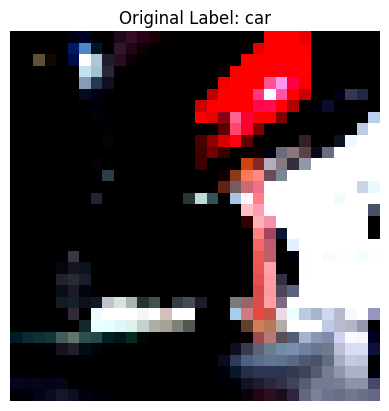

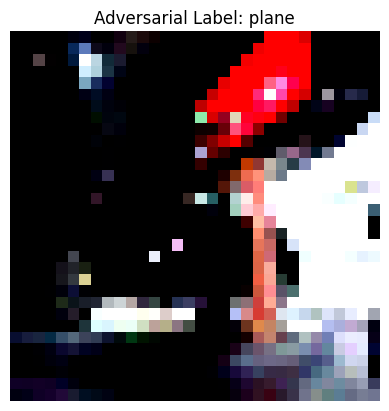

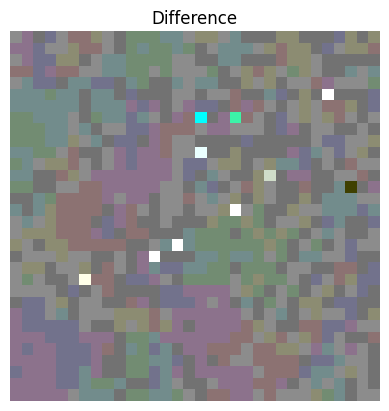

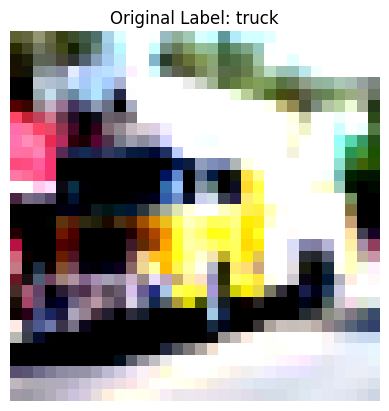

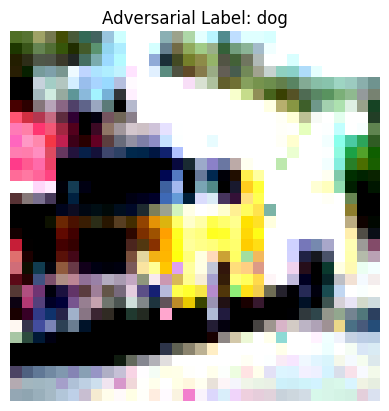

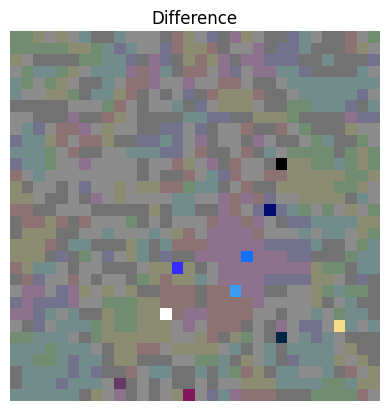

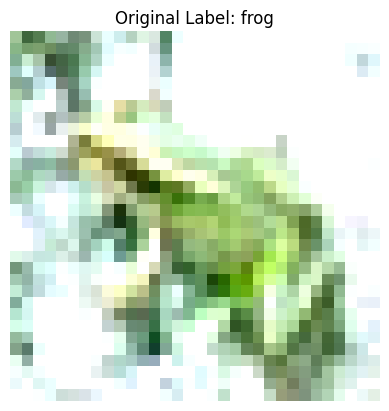

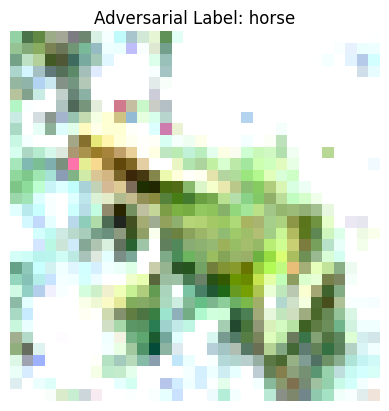

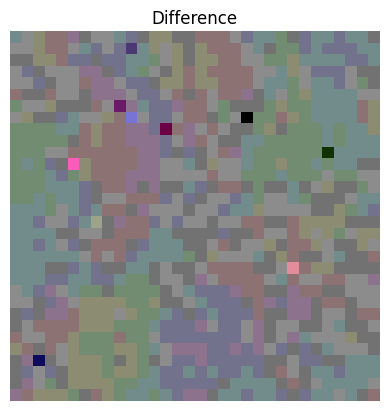

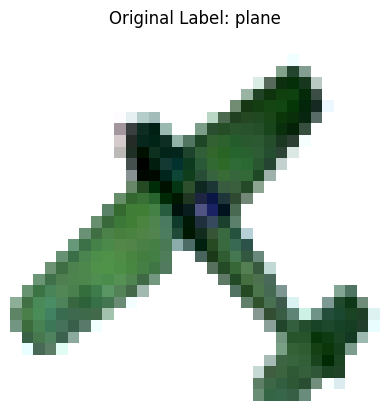

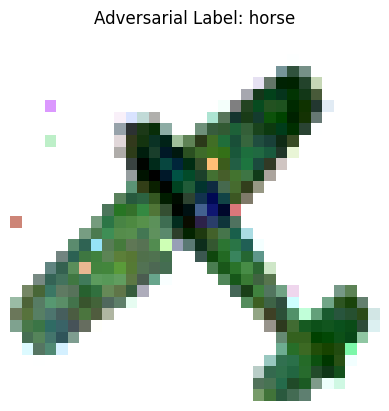

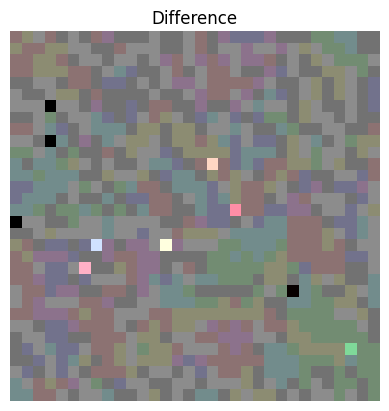

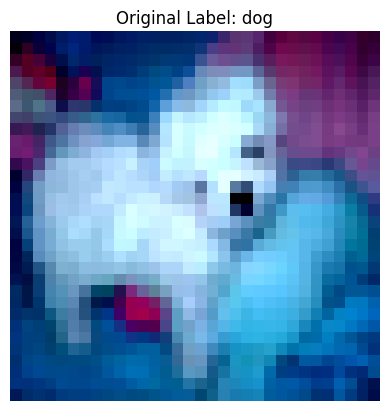

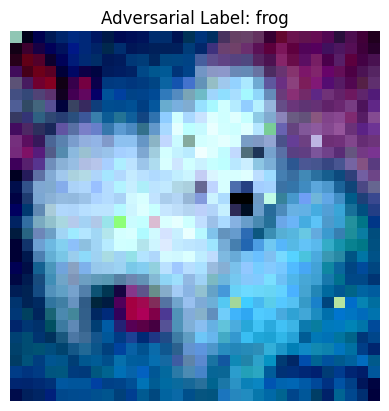

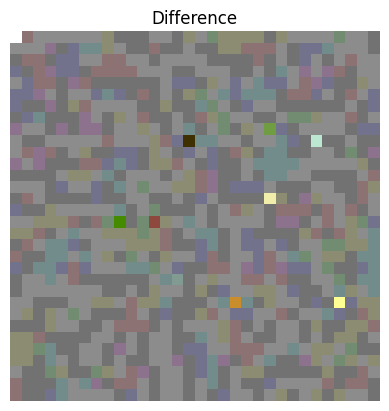

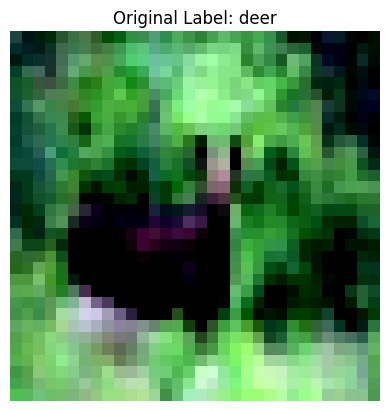

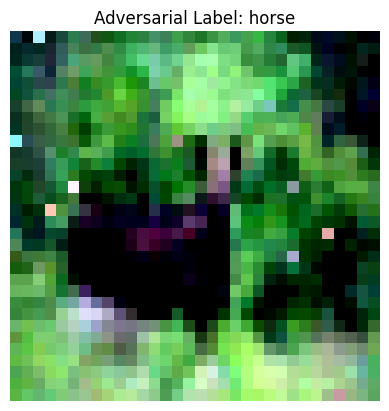

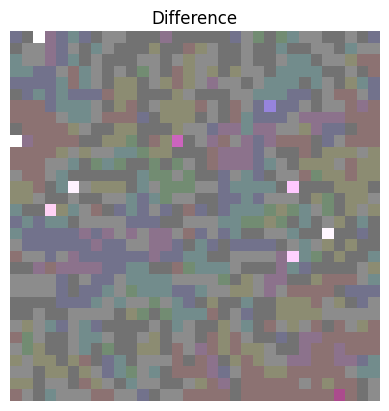

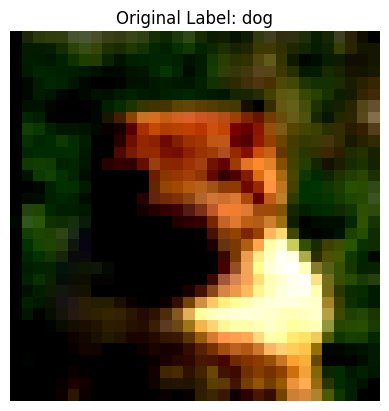

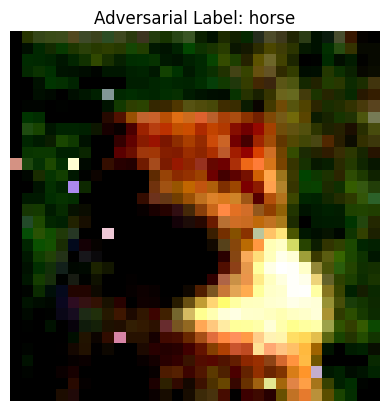

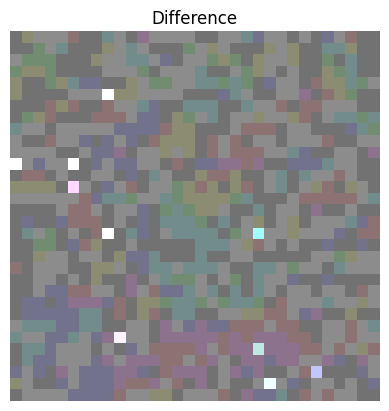

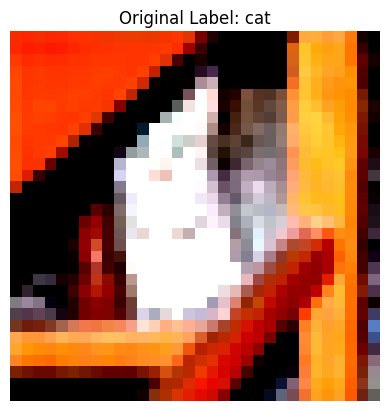

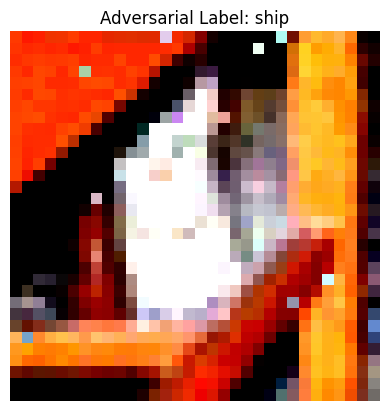

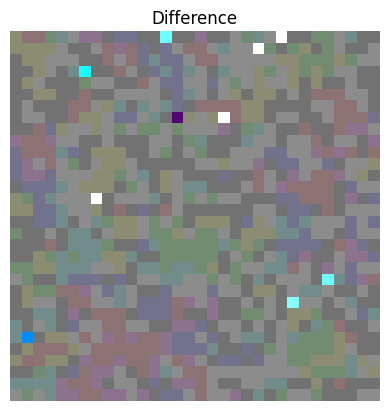

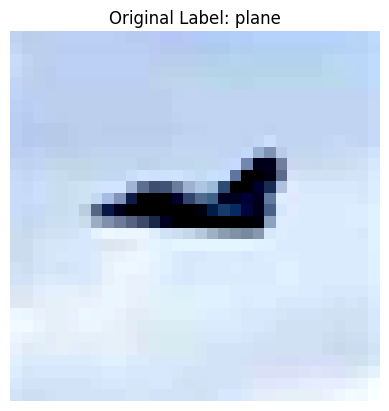

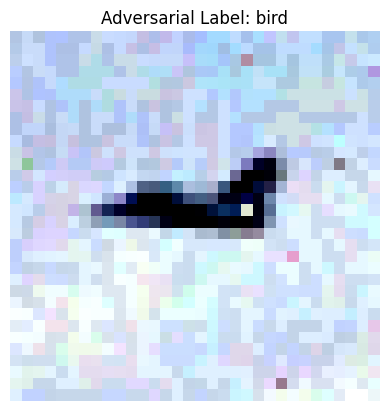

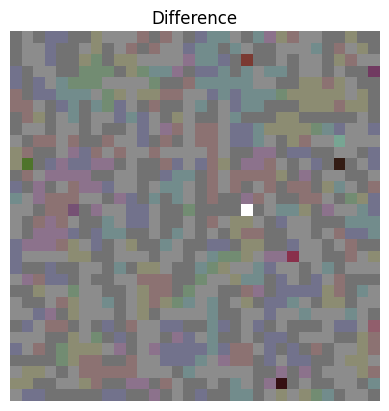

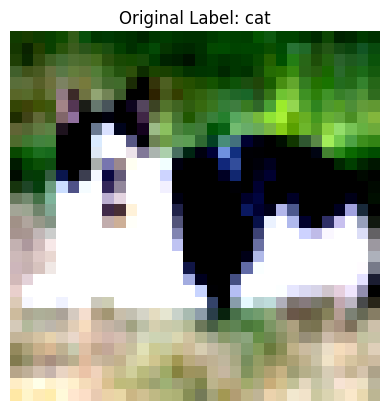

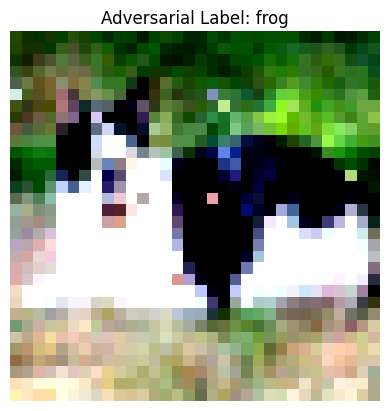

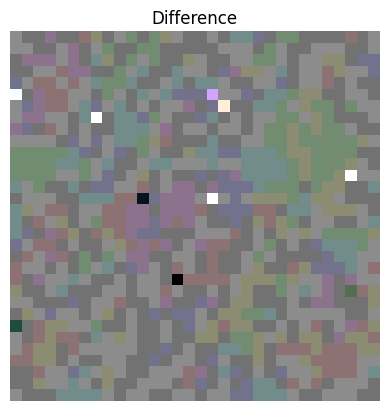

In [13]:
# Function to display images
def imshow(img, title=None):
    img = img.detach().cpu() / 2 + 0.5  # unnormalize and detach gradients
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Select 10 random indices
num_images = len(adversarial_test)
selected_indices = random.sample(range(num_images), 10)

# Display original and adversarial images along with labels
for idx in selected_indices:
    original_image = testset[idx][0].to(adversarial_test.device)  # Get original image from testset and move it to the same device
    original_label = original_labels_test[idx].item()

    adversarial_image = adversarial_test[idx]  # Get adversarial image
    adversarial_label = adversarial_labels_test[idx].item()

    difference = adversarial_image - original_image  # Calculate difference

    # Display original image
    imshow(original_image, title=f'Original Label: {classes[original_label]}')

    # Display adversarial image
    imshow(adversarial_image, title=f'Adversarial Label: {classes[adversarial_label]}')

    # Display difference
    imshow(difference, title='Difference')


# evaluation

in the second part, we evaluate model on original and adversarial data.
on this part, we used cross entropy loss function and UMAP.

In [8]:
def perturb_image(image, num_pixels=10):
    """
    Randomly perturb `num_pixels` pixels of the input image.
    """
    perturbed_image = image.clone()

    for _ in range(num_pixels):
        # Randomly select pixel coordinates
        x = random.randint(0, image.size(2) - 1)
        y = random.randint(0, image.size(3) - 1)

        # Randomly perturb pixel value
        perturbed_image[:, :, x, y] = torch.rand_like(perturbed_image[:, :, x, y])

    return perturbed_image


# Assuming net and testloader are already on GPU
def create_adversarial_dataset(model, testloader, epsilon):

    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(model.parameters(), lr=0.001),
        input_shape=(3, 32, 32),
        nb_classes=10,
    )
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    adversarial_examples = []
    original_labels = []
    adversarial_labels = []

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Perturb input images
        perturbed_inputs = perturb_image(inputs)

        # Generate adversarial examples
        adv_inputs = attack.generate(x=perturbed_inputs.cpu().numpy())

        adversarial_examples.append(torch.tensor(adv_inputs))  # Convert numpy array to tensor
        original_labels.append(labels)
        # adversarial_labels.append(adv_labels)

    adversarial_examples = torch.cat(adversarial_examples, dim=0).to(device)
    original_labels = torch.cat(original_labels, dim=0).to(device)

    return adversarial_examples, original_labels


Epoch [1/30], Train Loss: 0.9697, Validation Loss: 0.7658
Epoch [2/30], Train Loss: 0.5794, Validation Loss: 0.6822
Epoch [3/30], Train Loss: 0.4409, Validation Loss: 0.5895
Epoch [4/30], Train Loss: 0.3306, Validation Loss: 0.6160
Epoch [5/30], Train Loss: 0.2553, Validation Loss: 0.6776
Epoch [6/30], Train Loss: 0.2005, Validation Loss: 0.7273
Epoch [7/30], Train Loss: 0.1664, Validation Loss: 0.7551
Epoch [8/30], Train Loss: 0.1340, Validation Loss: 0.7566
Epoch [9/30], Train Loss: 0.1063, Validation Loss: 0.7876
Epoch [10/30], Train Loss: 0.0904, Validation Loss: 0.7529
Epoch [11/30], Train Loss: 0.0726, Validation Loss: 0.8302
Epoch [12/30], Train Loss: 0.0617, Validation Loss: 0.8514
Epoch [13/30], Train Loss: 0.0631, Validation Loss: 0.8112
Epoch [14/30], Train Loss: 0.0401, Validation Loss: 0.8606
Epoch [15/30], Train Loss: 0.0515, Validation Loss: 0.8098
Epoch [16/30], Train Loss: 0.0369, Validation Loss: 0.8308
Epoch [17/30], Train Loss: 0.0322, Validation Loss: 0.8828
Epoch 

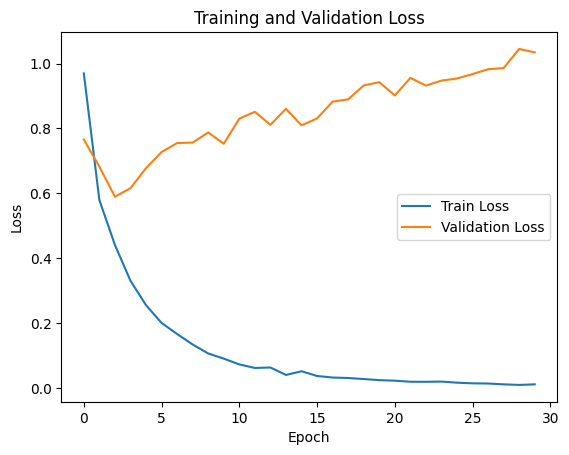

In [11]:

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(validloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    scheduler.step()

# Plotting the loss curve
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
adversarial_train, original_labels_train = create_adversarial_dataset(model, trainloader, epsilon)
adv_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_train, original_labels_train), batch_size=100, shuffle=True)


In [13]:
# Create adversarial dataset
adversarial_test, original_labels_test = create_adversarial_dataset(model, testloader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=100, shuffle=True)

print("Adversarial dataset created and saved successfully!")


Adversarial dataset created and saved successfully!


In [9]:
def test_model(model, dataloader,name):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Total number of examples
            total += labels.size(0)

            # Total number of correct predictions
            correct += (predicted == labels).sum().item()

    print('Accuracy on '+name+' data: {:.2f}%'.format(100 * correct / total))

accuracy:

In [20]:
# Test the model on clean data
test_model(model, testloader,'original data')

test_model(model, adv_test_loader,'adversarial data')

Accuracy on original data data: 82.54%
Accuracy on adversarial data data: 56.26%


In [ ]:
#UMAP
import torch
import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Define a function to get embeddings
def get_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# Get embeddings from the dataloader
embeddings_test, labels_test = get_embeddings(model, testloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_test = reducer.fit_transform(embeddings_test)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_test):
    indices = labels_test == label
    plt.scatter(embedding_umap_test[indices, 0], embedding_umap_test[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of test data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


In [ ]:

# Get embeddings from the dataloader
embeddings_adv, labels_adv = get_embeddings(model, adv_test_loader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_adv = reducer.fit_transform(embeddings_adv)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_adv):
    indices = labels_adv == label
    plt.scatter(embedding_umap_adv[indices, 0], embedding_umap_adv[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of adversarial test data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

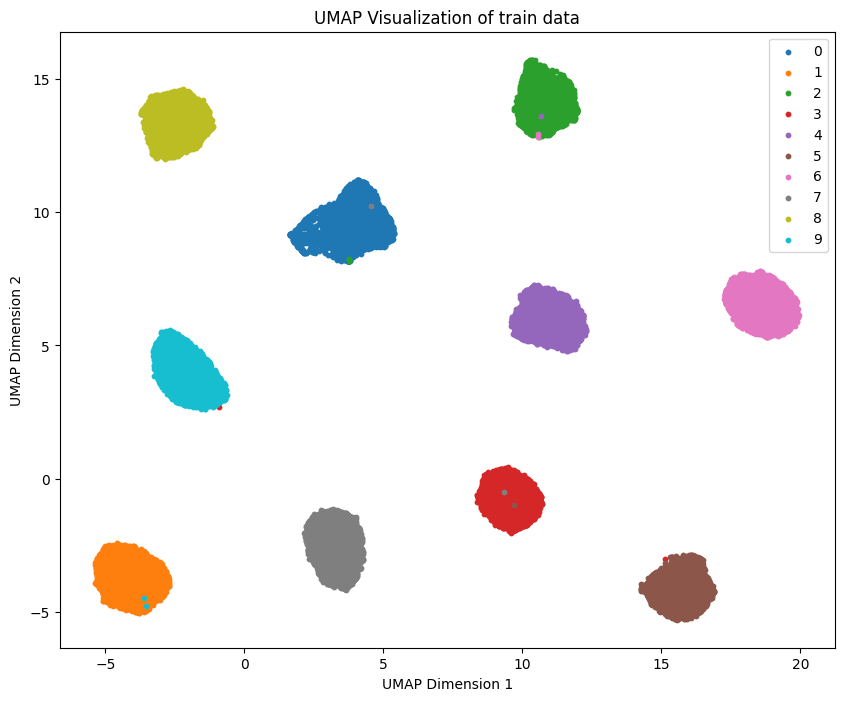

In [18]:
# Get embeddings from the dataloader
embeddings_train, labels_train = get_embeddings(model, trainloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_train = reducer.fit_transform(embeddings_train)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_train):
    indices = labels_train == label
    plt.scatter(embedding_umap_train[indices, 0], embedding_umap_train[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of train data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

In [26]:

knn_classifier = KNeighborsClassifier(n_neighbors=2)

knn_classifier.fit(embeddings_train, labels_train)

y_pred_original = knn_classifier.predict(embeddings_test)
y_pred_adversarial = knn_classifier.predict(embeddings_adv)

accuracy_original = accuracy_score(labels_test, y_pred_original)*100
accuracy_adversarial = accuracy_score(labels_adv, y_pred_adversarial)*100


In [27]:

print(f'Accuracy on original test set: {accuracy_original:.2f}%')
print(f'Accuracy on adversarial test set: {accuracy_adversarial:.2f}%')

Accuracy on original test set: 82.46%
Accuracy on adversarial test set: 55.93%


# augmented data

this time for training model, we used 50% adversarial data and 50% original data.

In [10]:
def create_adversarial_example(model, inputs, epsilon):
    inputs.requires_grad = True
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    grad = inputs.grad.data

    perturbed_inputs = inputs + epsilon * torch.sign(grad)
    perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)

    return perturbed_inputs

In [12]:


model = Net()
model.eval()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()
num_epochs=30
train_losses = []
val_losses = []
# Update the loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        if random.random() < 0.5:

            inputs = create_adversarial_example(model, inputs, 0.1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(validloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    scheduler.step()


Epoch [1/30], Train Loss: 1.4150, Validation Loss: 0.8065
Epoch [2/30], Train Loss: 1.0588, Validation Loss: 0.7910
Epoch [3/30], Train Loss: 0.9489, Validation Loss: 0.7678
Epoch [4/30], Train Loss: 0.8514, Validation Loss: 0.7042
Epoch [5/30], Train Loss: 0.7608, Validation Loss: 0.6417
Epoch [6/30], Train Loss: 0.6920, Validation Loss: 0.6293
Epoch [7/30], Train Loss: 0.6235, Validation Loss: 0.6281
Epoch [8/30], Train Loss: 0.5912, Validation Loss: 0.6613
Epoch [9/30], Train Loss: 0.5345, Validation Loss: 0.6383
Epoch [10/30], Train Loss: 0.4639, Validation Loss: 0.6473
Epoch [11/30], Train Loss: 0.4158, Validation Loss: 0.6845
Epoch [12/30], Train Loss: 0.4052, Validation Loss: 0.7823
Epoch [13/30], Train Loss: 0.3475, Validation Loss: 0.6954
Epoch [14/30], Train Loss: 0.3470, Validation Loss: 0.7156
Epoch [15/30], Train Loss: 0.2991, Validation Loss: 0.7572
Epoch [16/30], Train Loss: 0.3074, Validation Loss: 0.8439
Epoch [17/30], Train Loss: 0.2854, Validation Loss: 0.7633
Epoch 

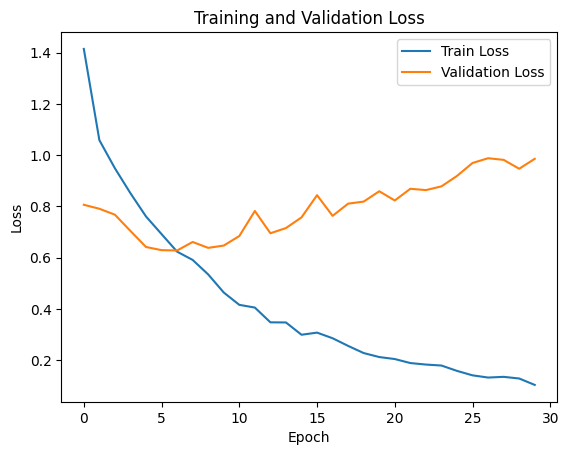

In [13]:
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
# Create adversarial dataset
adversarial_test, original_labels_test = create_adversarial_dataset(model, testloader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=100, shuffle=True)

print("Adversarial dataset created and saved successfully!")


Adversarial dataset created and saved successfully!


In [15]:
# Test the model on clean data


test_model(model, testloader,'original data')

test_model(model, adv_test_loader,'adversarial data')

Accuracy on original data data: 78.71%
Accuracy on adversarial data data: 63.43%


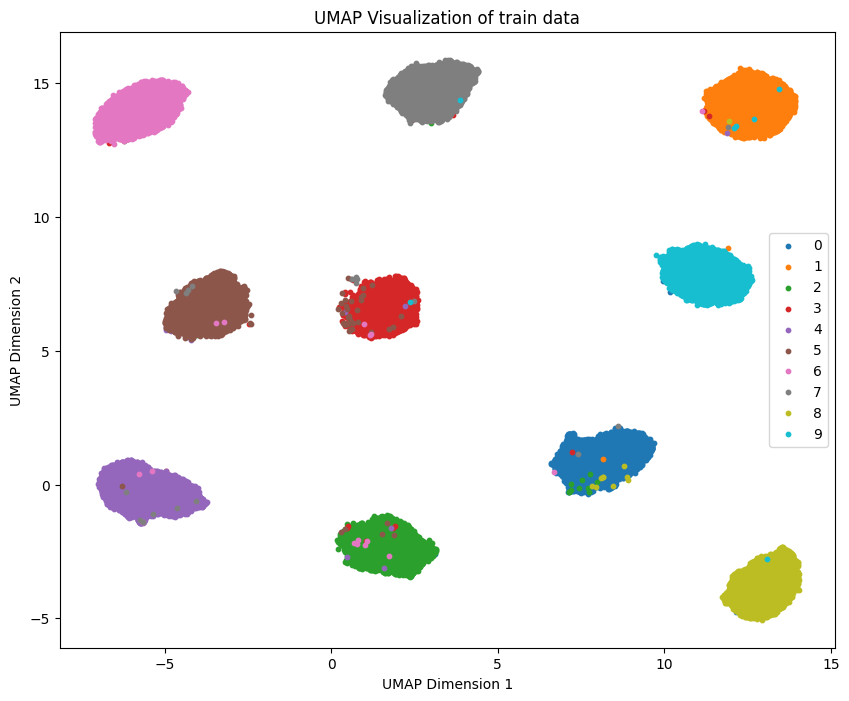

In [21]:
# Get embeddings from the dataloader
embeddings_train, labels_train = get_embeddings(model, trainloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_train = reducer.fit_transform(embeddings_train)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_train):
    indices = labels_train == label
    plt.scatter(embedding_umap_train[indices, 0], embedding_umap_train[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of train data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

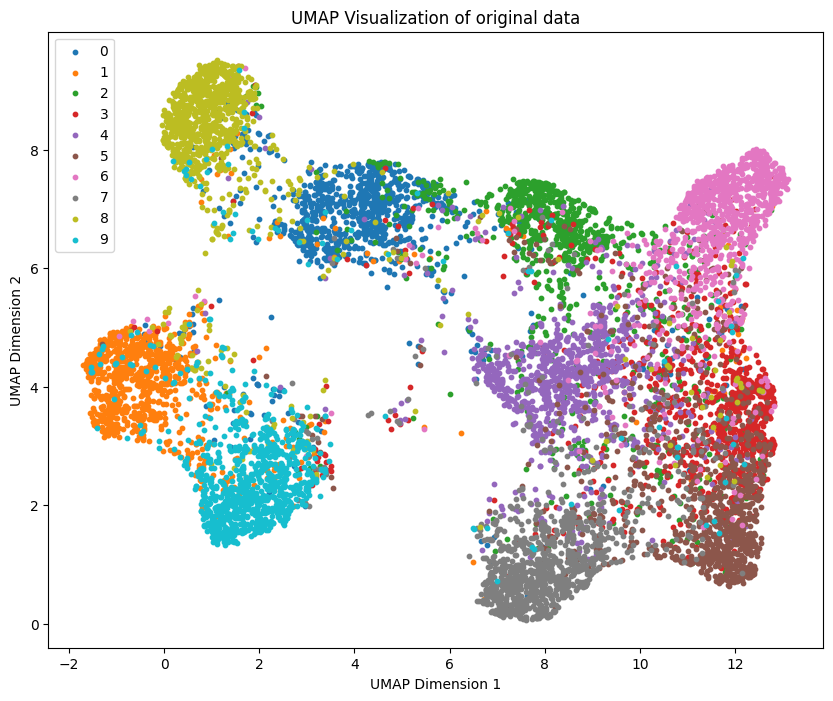

In [16]:
#UMAP
import torch
import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Define a function to get embeddings
def get_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# Get embeddings from the dataloader
embeddings_test, labels_test = get_embeddings(model, testloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_test = reducer.fit_transform(embeddings_test)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_test):
    indices = labels_test == label
    plt.scatter(embedding_umap_test[indices, 0], embedding_umap_test[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of original data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


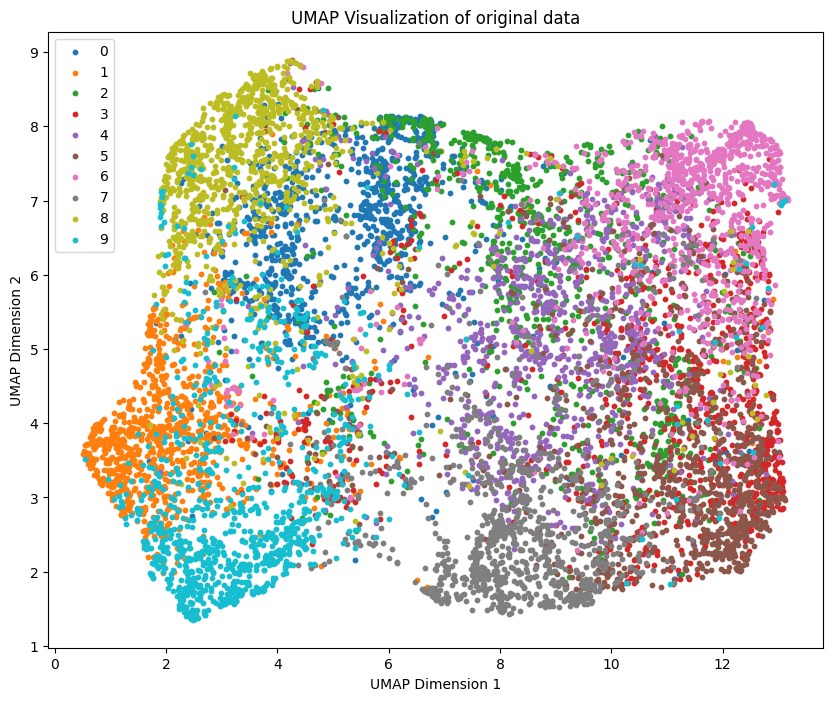

In [17]:

# Get embeddings from the dataloader
embeddings_adv, labels_adv = get_embeddings(model, adv_test_loader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_adv = reducer.fit_transform(embeddings_adv)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_adv):
    indices = labels_adv == label
    plt.scatter(embedding_umap_adv[indices, 0], embedding_umap_adv[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of original data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

In [28]:

knn_classifier = KNeighborsClassifier(n_neighbors=15)

knn_classifier.fit(embeddings_train, labels_train)

y_pred_original = knn_classifier.predict(embeddings_test)
y_pred_adversarial = knn_classifier.predict(embeddings_adv)

accuracy_original = accuracy_score(labels_test, y_pred_original)*100
accuracy_adversarial = accuracy_score(labels_adv, y_pred_adversarial)*100


In [29]:

print(f'Accuracy on original test set: {accuracy_original:.2f}%')
print(f'Accuracy on test set: {accuracy_adversarial:.2f}%')

Accuracy on original test set: 79.08%
Accuracy on test set: 64.66%


# using circle loss

this time, we used circle loss function:

Yifan Sun, Changmao Cheng, Yuhan Zhang, Chi Zhang, Liang Zheng,
Zhongdao Wang, and Yichen Wei. Circle loss: A unified perspective of pair
similarity optimization. In CVPR, pages 6398–6407, 2020.

In [58]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 128)  # Changing the output layer for CIFAR-10

    def forward(self, x):
        return self.resnet(x)

# Load pre-trained ResNet-18 model
model = Net()
model.eval()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = losses.CircleLoss(m=0.25, gamma=80)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 63.2723, Validation Loss: 60.6556
Epoch [2/30], Train Loss: 55.5915, Validation Loss: 55.5401
Epoch [3/30], Train Loss: 52.4141, Validation Loss: 52.5997
Epoch [4/30], Train Loss: 50.4873, Validation Loss: 50.8120
Epoch [5/30], Train Loss: 49.3423, Validation Loss: 50.2053
Epoch [6/30], Train Loss: 48.5239, Validation Loss: 49.6262
Epoch [7/30], Train Loss: 48.0133, Validation Loss: 48.7279
Epoch [8/30], Train Loss: 47.5925, Validation Loss: 48.6128
Epoch [9/30], Train Loss: 47.3184, Validation Loss: 48.0976
Epoch [10/30], Train Loss: 47.0337, Validation Loss: 47.8088
Epoch [11/30], Train Loss: 46.7256, Validation Loss: 47.7897
Epoch [12/30], Train Loss: 46.5262, Validation Loss: 47.4559
Epoch [13/30], Train Loss: 46.3205, Validation Loss: 47.4661
Epoch [14/30], Train Loss: 46.0554, Validation Loss: 47.0205
Epoch [15/30], Train Loss: 45.8171, Validation Loss: 46.7909
Epoch [16/30], Train Loss: 45.6399, Validation Loss: 46.7609
Epoch [17/30], Train Loss: 45.386

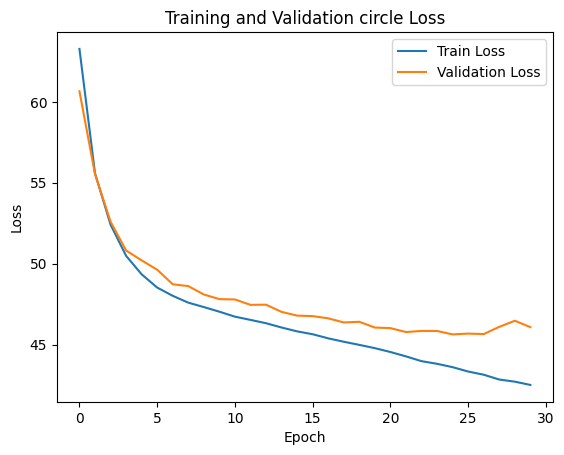

In [59]:

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(validloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    scheduler.step()

# Plotting the loss curve
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation circle Loss')
plt.legend()
plt.show()

In [60]:
adversarial_test, original_labels_test = create_adversarial_dataset(model, testloader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=100, shuffle=True)
print('ok')

ok


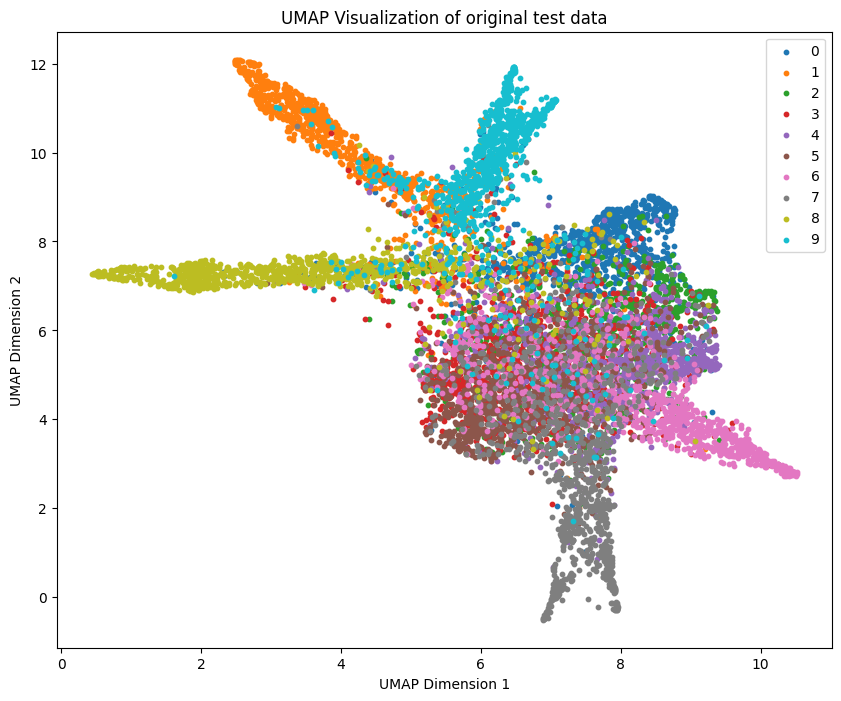

In [61]:

# Get embeddings from the dataloader
embeddings_test, labels_test = get_embeddings(model, testloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_test = reducer.fit_transform(embeddings_test)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_test):
    indices = labels_test == label
    plt.scatter(embedding_umap_test[indices, 0], embedding_umap_test[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of original test data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()


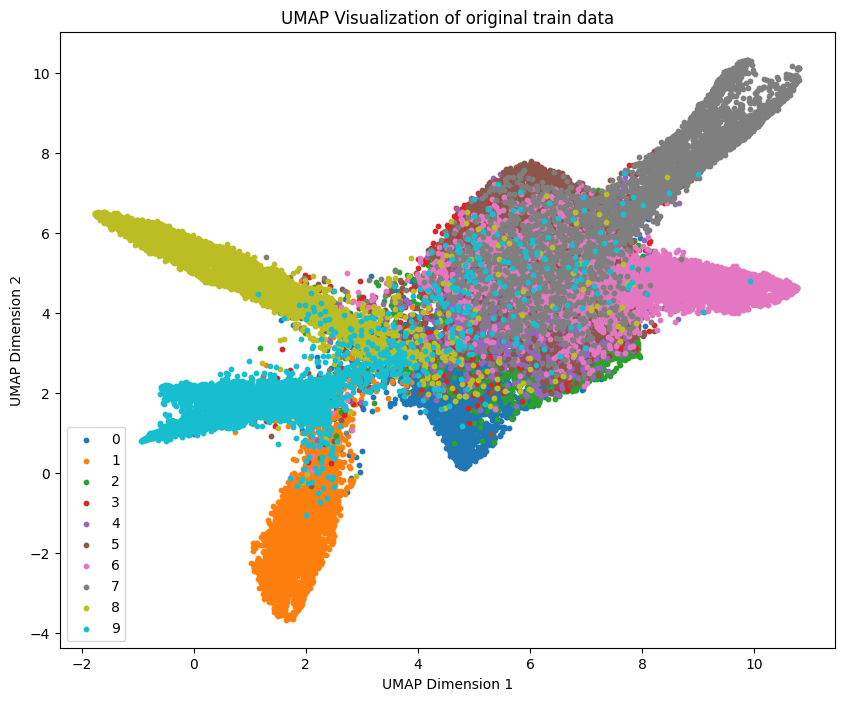

In [62]:
# Get embeddings from the dataloader
embeddings_train, labels_train = get_embeddings(model, trainloader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_train = reducer.fit_transform(embeddings_train)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_train):
    indices = labels_train == label
    plt.scatter(embedding_umap_train[indices, 0], embedding_umap_train[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of original train data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

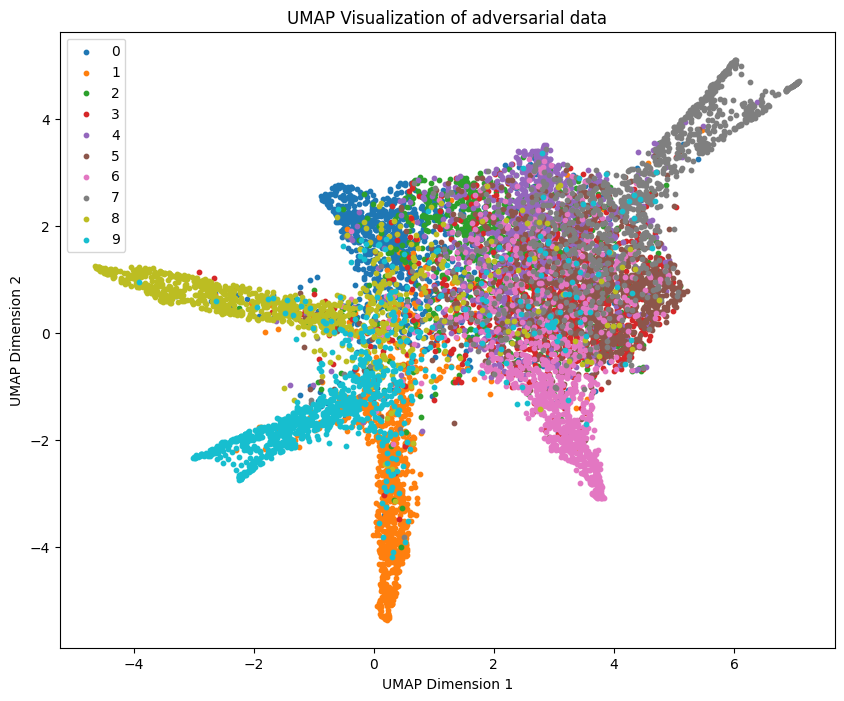

In [63]:

# Get embeddings from the dataloader
embeddings_adv, labels_adv = get_embeddings(model, adv_test_loader)

# Use UMAP to reduce dimensionality
reducer = UMAP()
embedding_umap_adv = reducer.fit_transform(embeddings_adv)

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels_adv):
    indices = labels_adv == label
    plt.scatter(embedding_umap_adv[indices, 0], embedding_umap_adv[indices, 1], label=label, s=10)
plt.title('UMAP Visualization of adversarial data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

In [64]:

knn_classifier = KNeighborsClassifier(n_neighbors=10)

knn_classifier.fit(embeddings_train, labels_train)

y_pred_original = knn_classifier.predict(embeddings_test)
y_pred_adversarial = knn_classifier.predict(embeddings_adv)

accuracy_original = accuracy_score(labels_test, y_pred_original)*100
accuracy_adversarial = accuracy_score(labels_adv, y_pred_adversarial)*100


In [68]:

print(f'Accuracy on original test set: {accuracy_original:.2f}%')
print(f'Accuracy on adversarial test set: {accuracy_adversarial:.2f}%')

Accuracy on original test set: 63.89%
Accuracy on adversarial test set: 61.20%
